In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle,Circle
from matplotlib.colors import LogNorm

from lanczos_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1 

In [3]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
def krylov_trace_restart_proj(A,g,r,b,q):
    
    assert b>0, 'b must be positive'
    
    d = A.shape[0]
   
    Ω = np.random.randn(d,b)

    λmin = 1/κ
    λmax = 1
    for i in range(r):
        QQ,M,R = block_lanczos(A,Ω,q,reorth=q)
        
        T = get_block_tridiag(M+[np.zeros((b,b))],R[1:])
        Θ,S = np.linalg.eigh(T)

        tt = np.polynomial.chebyshev.chebpts1(1000)
        xx = tt*1.0*(λmax-λmin)/2 + (λmax+λmin)/2
        yy = g(xx)
        p = np.polynomial.Chebyshev.fit(xx,yy,q)

        Y = S@np.diag(p(Θ))@S.conj().T[:,:b]
        Ω = QQ[:,:(q+1)*b]@Y@R[0]
    
    Θ_defl = np.array([])
    W_defl = np.array([])

    QQ,M,R = block_lanczos(A,Ω,q,reorth=q)
    
    return QQ

In [6]:
d = 2000

κ = 1000

Λ1 = 1/(1 + (np.arange(d)/(d-1))**2*(κ-1))
Λ2 = 1/((κ)**(np.arange(d)/(d-1))) 
Λ2 = 1/(1 + (np.arange(d)/(d-1))*(κ-1)*.99**(d-np.arange(1,d+1)))

Λs = [Λ1,Λ2]
Λ_names = ['slow','fast']

f = lambda x: 1/x

restart_lens = [0,2,4]
block_sizes = [1,2,4,8,16,32,64]
depths = list(range(4,65,4))
max_dim = 1024


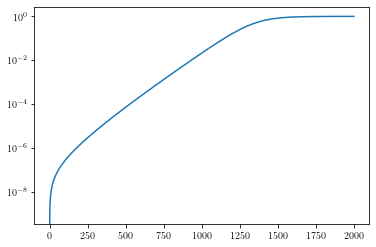

In [7]:
plt.plot(1-1/(1 + (np.arange(d)/(d-1))*(κ-1)*.99**(d-np.arange(1,d+1))))
plt.yscale('log')


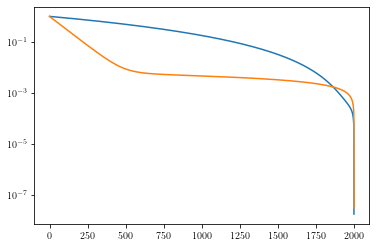

In [8]:
plt.plot((np.sum(f(Λ1)**2)-np.cumsum(f(Λ1)[::-1]**2))**.5/np.linalg.norm(f(Λ1)))
plt.plot((np.sum(f(Λ2)**2)-np.cumsum(f(Λ2)[::-1]**2))**.5/np.linalg.norm(f(Λ2)))
plt.yscale('log')

In [162]:
proj_error = [np.full((len(restart_lens),len(block_sizes),len(depths)),np.nan) for Λ in Λs]
orth = [np.zeros((len(restart_lens),len(block_sizes),len(depths))) for Λ in Λs]

for l,Λ in enumerate(Λs):
    A = np.diag(Λ)
    fA = np.diag(f(Λ))
    for i,r in enumerate(restart_lens):
        for j,b in enumerate(block_sizes):
            for k,q in enumerate(depths):
                if b*q > max_dim:
                    continue
                try:
                    g = lambda x: 1/x
                    np.random.seed(0)
                    Q = krylov_trace_restart_proj(A,g,r,b,q)
                    orth[l][i,j,k] = np.linalg.norm(Q.T@Q - np.eye(b*(q+1)))
                    P = np.eye(d)-Q@Q.T
                    proj_error[l][i,j,k] = np.linalg.norm(P@fA@P)/np.linalg.norm(fA)
                except:
                    proj_error[l][i,j,k] = np.nan

In [163]:
hpp_error = [np.full((len(block_sizes),len(depths)),np.nan) for Λ in Λs]

for l,Λ in enumerate(Λs):
    A = np.diag(Λ)
    fA = np.diag(f(Λ))
    for j,b in enumerate(block_sizes):

        np.random.seed(0)
        Ω = np.random.randn(d,b)
        Q_bar,M,R = block_lanczos(A,Ω,int(max_dim/b),reorth=q)
        
        for k,q in enumerate(depths):
            
            if b*q > max_dim:
                continue
            try:        
                T = get_block_tridiag(M[:q],R[1:q])
                Θ,S = np.linalg.eigh(T)
                
                fAΩ_approx = Q_bar[:,:b*q]@S@np.diag(f(Θ))@S.T@Q_bar[:,:b*q].T@Ω
                Q,_ = np.linalg.qr(fAΩ_approx)
                
                hpp_error[l][j,k] = np.linalg.norm((np.eye(d)-Q@Q.T)@fA@(np.eye(d)-Q@Q.T))/np.linalg.norm(fA)
            except:
                hpp_error[l][j,k] = np.nan

In [9]:
#np.save('ls_proj_error',proj_error)
#np.save('ls_hpp_error',hpp_error)

proj_error = np.load('ls_proj_error.npy')
hpp_error = np.load('ls_hpp_error.npy')

0
1


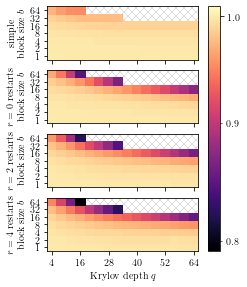

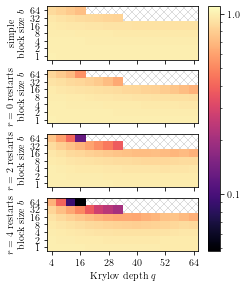

In [48]:
for l,Λ in enumerate(Λs):
    print(l)
    fig,axs = plt.subplots(len(restart_lens)+1,1,figsize=(3.5,4.5),sharex=True,sharey=True)
    plt.subplots_adjust(left=.2,right=.95)

    axs[0].patch.set(hatch='xxx',edgecolor='black')
    axs[0].set_ylabel(f'simple\nblock size $b$')

    for i,r in enumerate(restart_lens):
        if l == 0:
            pos = axs[i+1].pcolor(proj_error[l][i],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.01))
            axs[0].pcolor(hpp_error[l],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.01))
    
        else:
            pos = axs[i+1].pcolor(proj_error[l][i],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.1))
            axs[0].pcolor(hpp_error[l],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.1))
    
        axs[i+1].patch.set(hatch='xxx',edgecolor='black')
        
        axs[i+1].set_yticks(np.arange(len(block_sizes))+.5)

        axs[i+1].set_yticklabels(block_sizes)
        axs[i+1].set_ylabel(f'$r={r}$ restarts\nblock size $b$')

        axs[i+1].set_xticks(np.arange(len(depths))[::3]+.5)
        axs[i+1].set_xticklabels(depths[::3])
        axs[-1].set_xlabel('Krylov depth $q$')

        axs[i+1].set_title(f'')

    cb = fig.colorbar(pos,ax=axs)
    #if l==0:
    #    cb.ax.yaxis.set_minor_formatter(lambda x, _: f"${x:1.2e}".replace("e", ' \\times 10^{').replace("+0", "").replace("-0", "-") + '}$')
    #else:
    
    cb.ax.yaxis.set_major_formatter(lambda x, _: f"${x:1.1f}$")#.replace("e", ' \\times 10^{').replace("+0", "").replace("-0", "-") + '}$')
    if l==0:
        cb.ax.yaxis.set_minor_formatter(lambda x, _: f"${x:1.1f}$")
    plt.savefig(f'imgs/proj_quality_{Λ_names[l]}.pdf')

0
1


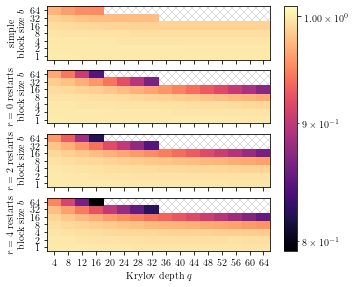

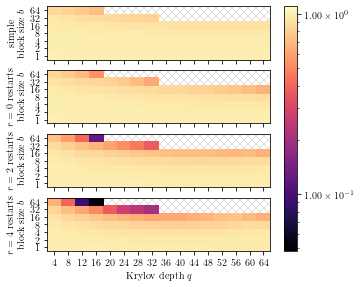

In [11]:
for l,Λ in enumerate(Λs):
    print(l)
    fig,axs = plt.subplots(len(restart_lens)+1,1,figsize=(5,4.5),sharex=True,sharey=True)

    axs[0].patch.set(hatch='xxx',edgecolor='black')
    axs[0].set_ylabel(f'simple\nblock size $b$')

    for i,r in enumerate(restart_lens):
        if l == 0:
            pos = axs[i+1].pcolor(proj_error[l][i],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.01))
            axs[0].pcolor(hpp_error[l],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.01))
    
        else:
            pos = axs[i+1].pcolor(proj_error[l][i],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.1))
            axs[0].pcolor(hpp_error[l],cmap='magma',norm=LogNorm(np.nanmin(proj_error[l])*1.,1.1))
    
        axs[i+1].patch.set(hatch='xxx',edgecolor='black')
        
        axs[i+1].set_yticks(np.arange(len(block_sizes))+.5)

        axs[i+1].set_yticklabels(block_sizes)
        axs[i+1].set_ylabel(f'$r={r}$ restarts\nblock size $b$')

        axs[i+1].set_xticks(np.arange(len(depths))+.5)
        axs[i+1].set_xticklabels(depths)
        axs[-1].set_xlabel('Krylov depth $q$')

        axs[i+1].set_title(f'')

    cb = fig.colorbar(pos,ax=axs)
    #if l==0:
    #    cb.ax.yaxis.set_minor_formatter(lambda x, _: f"${x:1.2e}".replace("e", ' \\times 10^{').replace("+0", "").replace("-0", "-") + '}$')
    #else:
    cb.ax.yaxis.set_major_formatter(lambda x, _: f"${x:1.2e}".replace("e", ' \\times 10^{').replace("+0", "").replace("-0", "-") + '}$')
    
    plt.savefig(f'imgs/proj_quality_{Λ_names[l]}.pdf',bbox_inches='tight')

In [91]:
16*64

1024

In [51]:
k1 = 200
np.linalg.norm(A-Q[:,:k1]@Q[:,:k1].T@A@Q[:,:k1]@Q[:,:k1].T)/np.linalg.norm(A)

0.9298844211061406

In [131]:
np.random.seed(0)

b = 16
q = 20

Ω = np.random.randn(d,b)

A = np.diag(Λ2)
fA = np.diag(f(Λ2))  

Q,M,R = block_lanczos(A,Ω,q,reorth=q)
T = get_block_tridiag(M+[np.zeros((b,b))],R[1:])


In [49]:

plt.plot(np.linalg.norm((A@Q - Q@T)[:,:-b],axis=0))
plt.yscale('log')

NameError: name 'A' is not defined

In [67]:
np.linalg.norm((Q.T@Q - np.eye(b*(q+1))))

9.580687334306043

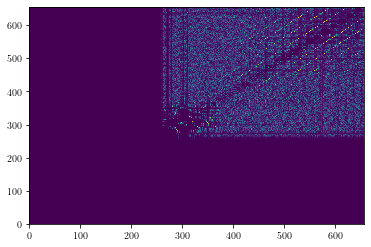

In [63]:
plt.pcolor(np.abs(Q.T@Q - np.eye(b*(q+1))))

In [190]:
np.logspace(-15,0,10000)

array([3.16993316e-05, 3.18090175e-05, 3.19190829e-05, ..., 9.93115362e-01, 9.96551736e-01, 1.00000000e+00])

In [67]:
n_colors = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis([0,.1,.4,.8])


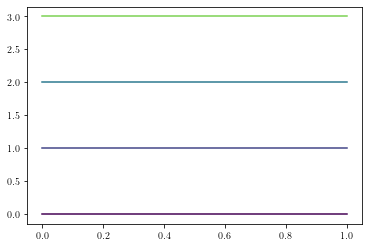

In [66]:
for i in range(4):
    plt.plot([0,1],[i,i])